In [1]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import matplotlib
import numpy as np 
import pandas as pd

from utils import *

def plot_legend(ax, alpha=0.25, loc=(0.3,0.2), anchor=(0,0)):
    for k,v in sorted(ALL_WINDOW_PROPERTIES.items()):
        ax.scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
    ax.legend(bbox_transform=ax.transAxes, loc=loc, bbox_to_anchor=anchor, ncols=len(ALL_WINDOW_PROPERTIES))
    
def plot_intervals(intervals, ax, alpha=0.25, color='red'):
    for interval in intervals:
        ax.axvspan(*interval, alpha=alpha, color=color, linewidth=0)
        
def plot_intervals_endpoints(intervals, ax, alpha=0.25, color='red'):
    for interval in intervals:
        ax.axvline(interval[0], alpha=alpha, color=color, linewidth=1)
        

def init_axis(ax, start_time, finish_time):
    ax.set_xlim(start_time, finish_time)
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)


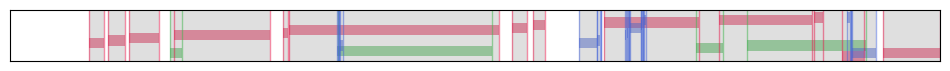

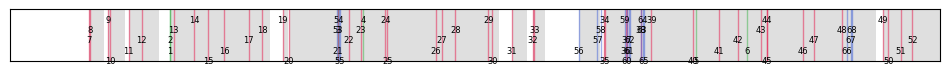

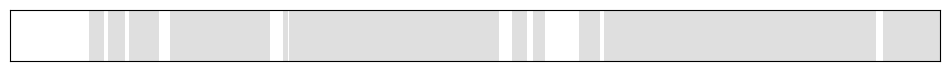

In [72]:
# FAILURE BARS FOR INDIVIDUALS ON EACH TASK 
data = load_nested_dict('data/Processed') 

def plot_failure_bars(data, participant, experiment):
    _data1 = data[participant]
    
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12,2))
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    print(_data1.keys())
    _data2 = _data1[experiment]
    
    start_time, finish_time =  _data2['start_time'], _data2['finish_time']
    
    # plot failure intervals
    for ax, (task, _data3) in zip(axes.ravel(), _data2['tasks'].items()):
        init_axis(ax, start_time, finish_time)
        #ax.set_ylabel(task[0].capitalize(), rotation=0)
        ax.yaxis.set_label_coords(-0.015, 0.3)
        intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
        for interval in intervals:
            plot_intervals(interval, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        
    plot_legend(ax, anchor=(0.3,-0.7))
    fig.suptitle(f"{participant} {experiment[3:]}")
    plt.show()
    
def plot_failure_proportion(data, participant, experiment):
    _data1 = data[participant]
    fig = plt.figure(figsize=(12,2/3))
    _data2 = _data1[experiment]
    start_time, finish_time =  _data2['start_time'], _data2['finish_time']
    all_intervals = []
    ax = plt.gca()    
    init_axis(ax, start_time, finish_time)
    for task, _data3 in _data2['tasks'].items():
        intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
        intervals = merge_intervals(intervals)
       # plot_intervals(intervals, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        all_intervals.append(intervals)
        
    plot_intervals(merge_intervals(all_intervals), ax, color='grey')
    #fig.suptitle(f"{participant} {experiment[3:]}", y=1.1, verticalalignment='center')
    return fig 
    
def plot_failure_count(data, participant, experiment):
    _data1 = data[participant]
    fig = plt.figure(figsize=(12,2/3))
    _data2 = _data1[experiment]
    start_time, finish_time =  _data2['start_time'], _data2['finish_time']
    all_intervals = []
    i_all_intervals = []
    ax = plt.gca()    
    init_axis(ax, start_time, finish_time)
    count = 0
    for task, _data3 in _data2['tasks'].items():
        intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
        
        for i in sorted([i[0] for _inte in intervals for i in _inte]):
            count += 1
            ax.axvline(i, alpha=0.5, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1)
            ax.text(i, (0.2 * count)%1, str(count), fontsize=6, ha='center', va='center')
             
        intervals = merge_intervals(intervals)
        
       # plot_intervals(intervals, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        all_intervals.append(intervals)
        
    plot_intervals(merge_intervals(all_intervals), ax, color='grey')
    #fig.suptitle(f"{participant} {experiment[3:]}", y=1.1, verticalalignment='center')
    return fig


def plot_failure_length(data, participant, experiment):
    _data1 = data[participant]
    fig = plt.figure(figsize=(12,2/3))
    _data2 = _data1[experiment]
    start_time, finish_time =  _data2['start_time'], _data2['finish_time']
    all_intervals = []
    ax = plt.gca()    
    init_axis(ax, start_time, finish_time)
    count = 0
    y_center = (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2
    xlim = ax.get_xlim()
    
    for task, _data3 in _data2['tasks'].items():
        intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
        color = ALL_WINDOW_PROPERTIES[task]['color']
        intervals = merge_intervals(intervals)

        for i in sorted(intervals, key = lambda i : i[0]):
            count += 1
            ax.axvline(i[0], alpha=0.5, color=color, linewidth=1)
            ax.axvline(i[1], alpha=0.5, color=color, linewidth=1)
            xmin_rel = (i[0] - xlim[0]) / (xlim[1] - xlim[0])
            xmax_rel = (i[1] - xlim[0]) / (xlim[1] - xlim[0])
            y = (count * 0.05)%0.8 + 0.1

            #ax.axhline(y=(count * 0.2)%1, xmin=xmin_rel, xmax=xmax_rel, alpha=0.5, color=color)
            ax.axvspan(*i, ymax=y+0.1, ymin=y-0.1, alpha=0.5, color=color, linewidth=0)
               
            
       # plot_intervals(intervals, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        all_intervals.append(intervals)
        
    plot_intervals(merge_intervals(all_intervals), ax, color='grey')
    #fig.suptitle(f"{participant} {experiment[3:]}", y=1.1, verticalalignment='center')
    return fig

participant = "P04"
exp = participant + "icuB"

plot_failure_length(data, participant, exp)
plt.savefig(f"./failure_length_{exp}.png", bbox_inches="tight")


plot_failure_count(data, participant, exp)
plt.savefig(f"./failure_count_{exp}.png", bbox_inches="tight")

plot_failure_proportion(data, participant, exp)
plt.savefig(f"./failure_proportion_{exp}.png", bbox_inches="tight")



#for exp in data[participant].keys():

 
    #plot_failure_proportion(data, participant, exp)
    #plot_failure_bars(data, participant, exp)
    
    

# for participant in data.keys():
#     for exp in data[participant].keys():
#         plot_failure_bars(data, participant, exp)

In [ ]:

def plot_eyetracking(data, participant, experiment, ax, show_out_of_bounds=False):
    eye_data = data[participant][participant + experiment]['eye_tracking']
    img = ICU_BACKGROUND_IMAGE
    WINDOW_SIZE = (800,800)
    ax.imshow(img, alpha=0.3)
    t, x, y, gaze = eye_data['timestamp'].astype(np.float32), eye_data['x'].astype(np.float32), eye_data['y'].astype(np.float32), eye_data['gaze'].to_numpy()
    x_gaze, y_gaze = x[gaze], y[gaze]
    ax.scatter(x[np.logical_not(gaze)], y[np.logical_not(gaze)], alpha=0.1, marker=".", color="black")
    not_in_any_task = []
    for _, properties in ALL_WINDOW_PROPERTIES.items():
        in_task = in_box(x_gaze, y_gaze, properties['position'], properties['size']).to_numpy()
        ax.scatter(x_gaze[in_task], y_gaze[in_task], color=properties['color'], marker=".", alpha=0.5)
        #rect = plt.Rectangle(properties['position'], *properties['size'], color="red",  linewidth=2, fill=False)
        #plt.gca().add_patch(rect)
        not_in_any_task.append(in_task)
    from functools import reduce
    not_in_any_task = np.logical_not(reduce(np.logical_or, not_in_any_task))
    ax.scatter(x_gaze[not_in_any_task], y_gaze[not_in_any_task], color='black', marker=".", alpha=0.5)
    if not show_out_of_bounds:
        pass 
        ax.set_xlim(0,WINDOW_SIZE[0])
        ax.set_ylim(0,WINDOW_SIZE[1])
        ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    
    
data = load_nested_dict('data/Processed') 
participants = list(data.keys())
experiments = list(next(iter(data.values())).keys())

fig, axes = plt.subplots(figsize=(12,48), nrows=len(participants), ncols=len(experiments),
                         gridspec_kw = {'wspace':0.01, 'hspace':0.05})

for par, _axes in zip(participants, axes):
    for exp, ax in zip(experiments, _axes):
        plot_eyetracking(data, par, exp[3:], ax, show_out_of_bounds=False)

for par, ax in zip(participants, axes[:,0]):
    ax.text(-0.1, 0.5, par, transform=ax.transAxes, rotation=90, va='center', ha='center', fontsize=14)

for exp, ax in zip(experiments, axes[0]):
    ax.set_title(exp[3:],fontsize=14)

Error in callback <function flush_figures at 0x7f09ca45e9e0> (for post_execute):


KeyboardInterrupt: 

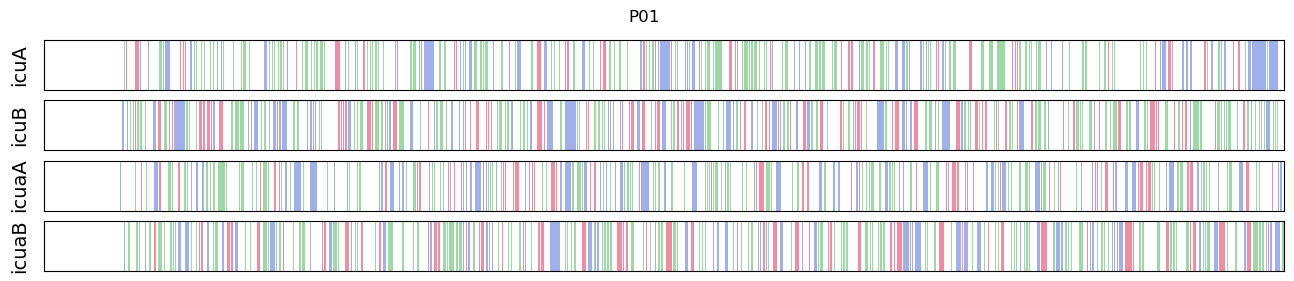

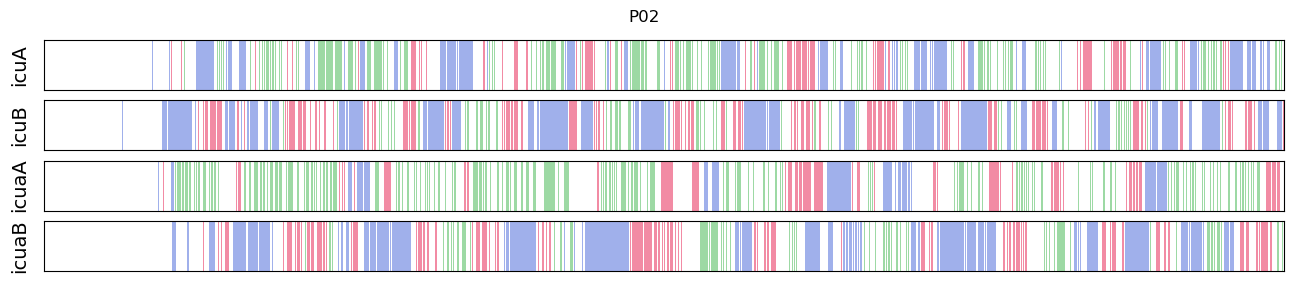

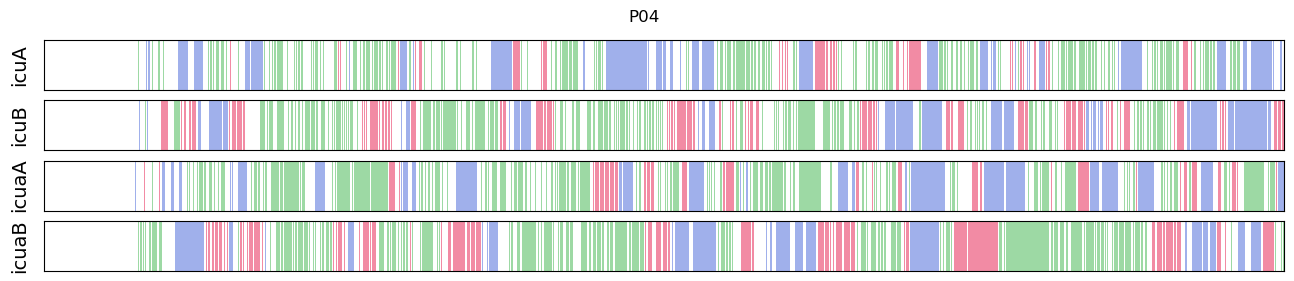

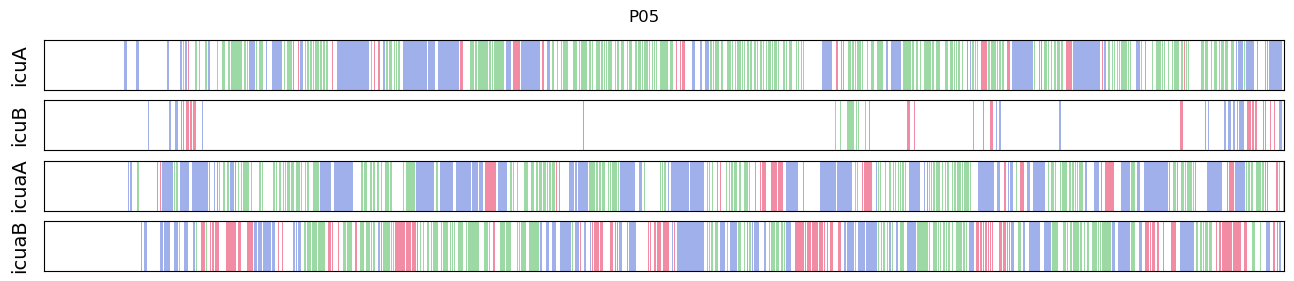

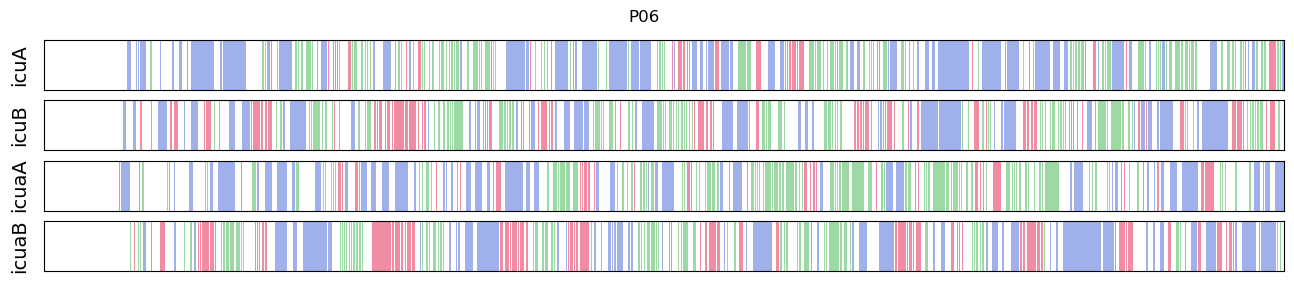

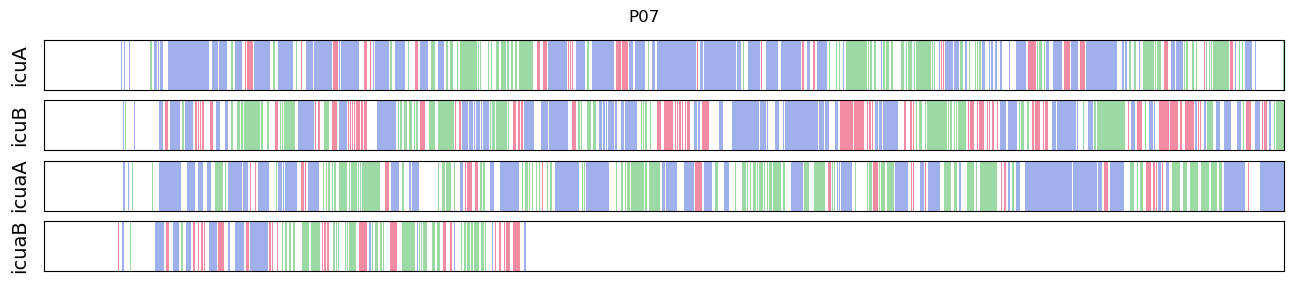

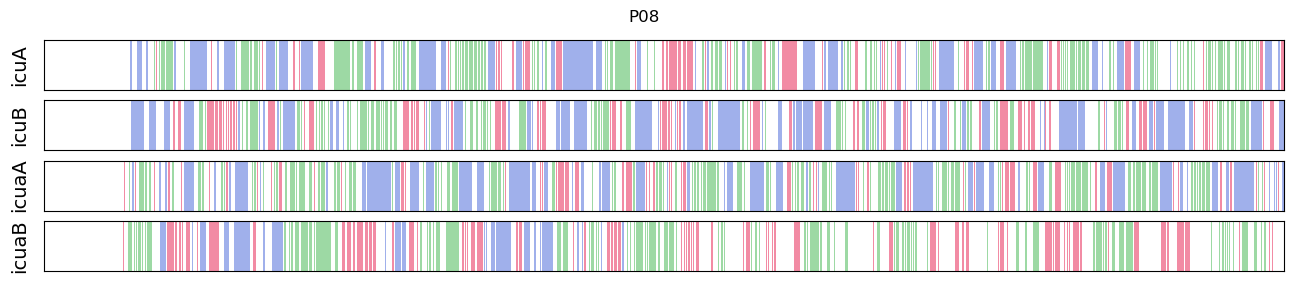

In [5]:
# PLOT GAZE INTERVALS

alpha = 0.5
plot_input = False
data = load_nested_dict('data/Processed') 
for participant, _data1 in data.items(): #itertools.islice(data.items(), 1):
    fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,3))
    fig.suptitle(participant)
    #plt.subplots_adjust(wspace=0.1, hspace=0.2)
    for ax, (experiment, _data2) in zip(axes, _data1.items()):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        init_axis(ax, start_time, finish_time)
        ax.set_ylabel(experiment[3:], fontsize=14)
        eye_data = _data2['eye_tracking']
        gaze = eye_data['gaze'].to_numpy()
        for task, window_properties in ALL_WINDOW_PROPERTIES.items():
            intaskbox = in_box(eye_data['x'].to_numpy(), eye_data['y'].to_numpy(), window_properties['position'], window_properties['size'])
            gazeintaskbox = np.logical_and(intaskbox, gaze)
            # pad with next, the person is not gazing the whole time if the eyetracker crashes/never produces another event.
            result = compute_time_intervals(gazeintaskbox, eye_data['timestamp'].to_numpy(), start_time, finish_time, pad='next')
            plot_intervals(result.intervals, ax, color=window_properties['color'], alpha=alpha)
            #print(result.intervals[0])
            #print(plt.gca().get_xlim())
            
        if plot_input:
            # plot clicks
            mouse_data = _data2['mouse']
            for task, data in mouse_data.groupby(mouse_data['task']):
                for x in data['timestamp']:
                    ax.axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1, fillstyle='none')
            # plot keyboard
            kdata = _data2['keyboard']
            for x in kdata['timestamp'][kdata['action'] == 'press']:
                ax.axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1, fillstyle='none')
            
        #plt.savefig(f'./results/gaze/{participant}.png', bbox_inches='tight')
    #plot_legend(axes.ravel()[-1], alpha=alpha, loc="lower center", anchor=(0.5,-1))
    plt.savefig(f'./results/gaze/{participant}.png', bbox_inches='tight')


  participant experiment      fuel    system  tracking     total
0         P01       icuA  0.025906  0.144143       0.0  0.170048
1         P01       icuB  0.221410  0.332373       0.0  0.459953
2         P01      icuaA  0.015035  0.125623       0.0  0.140658
3         P01      icuaB  0.132822  0.254217       0.0  0.346320


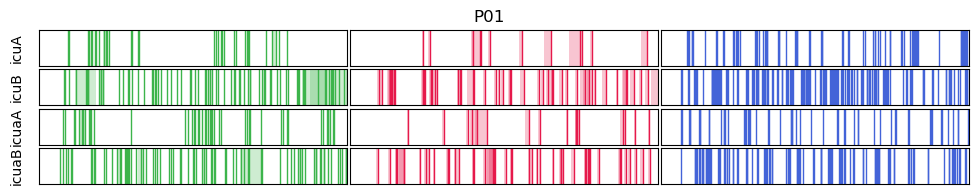

  participant experiment      fuel    system  tracking     total
4         P02       icuA  0.764953  0.235492  0.000000  0.764953
5         P02       icuB  0.650983  0.554128  0.030489  0.822014
6         P02      icuaA  0.749124  0.372798  0.000000  0.749124
7         P02      icuaB  0.780141  0.654670  0.124805  0.874677


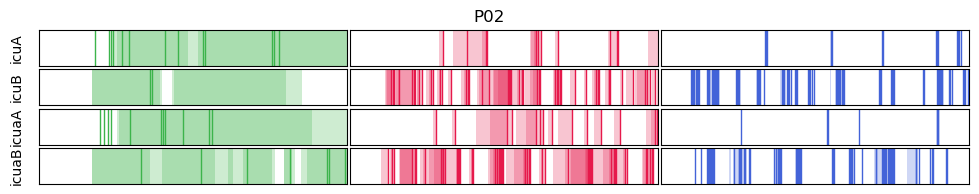

   participant experiment      fuel    system  tracking     total
8          P04       icuA  0.000000  0.345895  0.013411  0.348942
9          P04       icuB  0.335931  0.730108  0.076316  0.812973
10         P04      icuaA  0.072624  0.300994  0.000000  0.346533
11         P04      icuaB  0.766763  0.672729  0.070085  0.862713


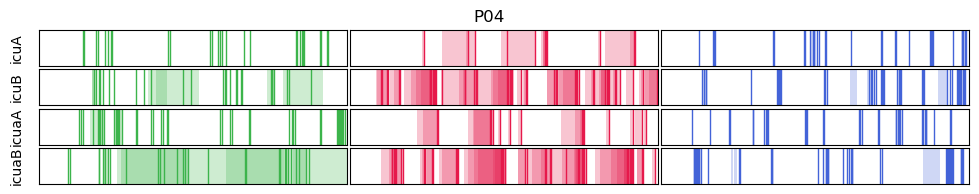

   participant experiment      fuel    system  tracking     total
12         P05       icuA  0.613030  0.219026  0.000000  0.635587
13         P05       icuB  0.623566  0.906782  0.094996  0.911663
14         P05      icuaA  0.000000  0.193593  0.000000  0.193593
15         P05      icuaB  0.589457  0.822079  0.091000  0.863283


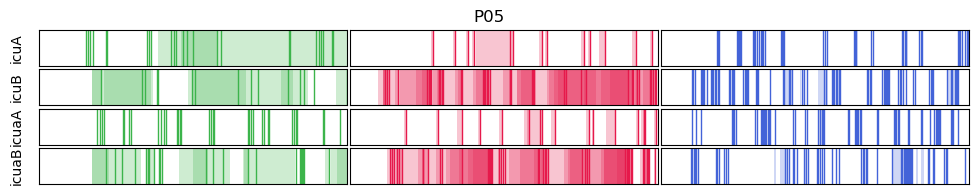

   participant experiment      fuel    system  tracking     total
16         P06       icuA  0.019173  0.093507  0.000000  0.112680
17         P06       icuB  0.421528  0.584714  0.006405  0.793016
18         P06      icuaA  0.382667  0.190409  0.000000  0.508977
19         P06      icuaB  0.732156  0.701878  0.013079  0.819412


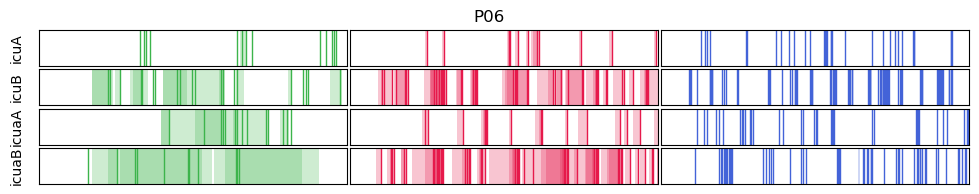

   participant experiment      fuel    system  tracking     total
20         P07       icuA  0.089291  0.118164  0.000582  0.191217
21         P07       icuB  0.382481  0.513418  0.166484  0.757468
22         P07      icuaA  0.000000  0.131267  0.000000  0.131267
23         P07      icuaB  0.568586  0.685349  0.084658  0.846352


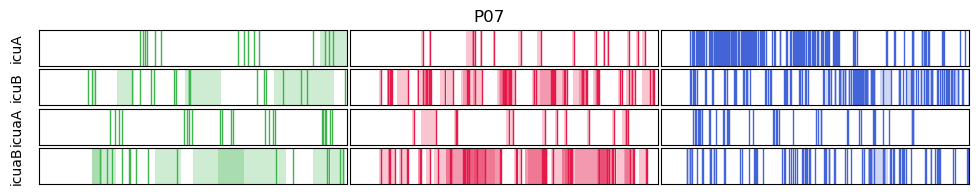

   participant experiment      fuel    system  tracking     total
24         P08       icuA  0.477692  0.122348  0.000000  0.537195
25         P08       icuB  0.601126  0.447398  0.020236  0.753385
26         P08      icuaA  0.072187  0.105580  0.000000  0.169511
27         P08      icuaB  0.107953  0.539057  0.049343  0.575844


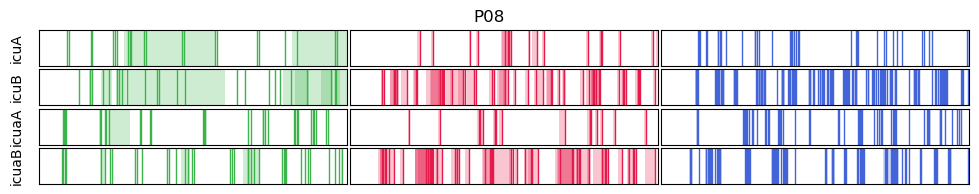

   participant experiment      fuel    system  tracking     total
28         P09       icuA  0.109804  0.136970  0.000000  0.220562
29         P09       icuB  0.190957  0.592540  0.043335  0.626996
30         P09      icuaA  0.316796  0.201481  0.000000  0.490798
31         P09      icuaB  0.238917  0.614350  0.012568  0.720709


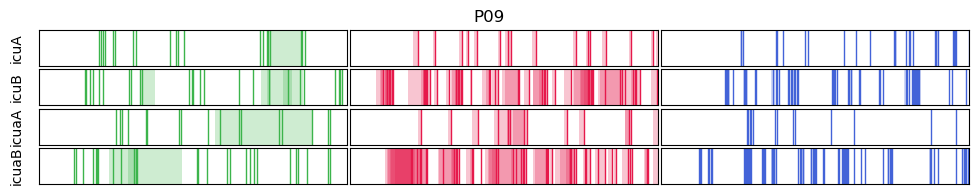

   participant experiment      fuel    system  tracking     total
32         P10       icuA  0.000000  0.177597  0.000000  0.177597
33         P10       icuB  0.501275  0.562989  0.010911  0.747084
34         P10      icuaA  0.000000  0.165719  0.000000  0.165719
35         P10      icuaB  0.486551  0.618170  0.063854  0.763058


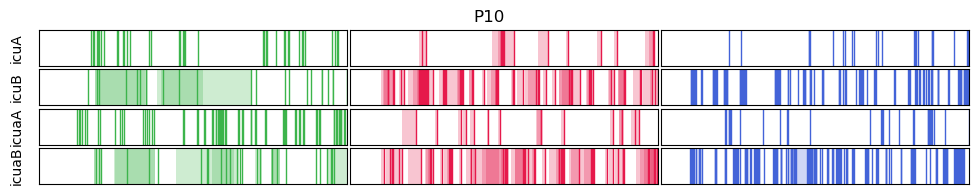

   participant experiment      fuel    system  tracking     total
36         P16       icuA  0.730797  0.435608  0.000000  0.786611
37         P16       icuB  0.460614  0.777649  0.087025  0.856202
38         P16      icuaA  0.307071  0.432558  0.000000  0.552437
39         P16      icuaB  0.633636  0.824258  0.047605  0.883962


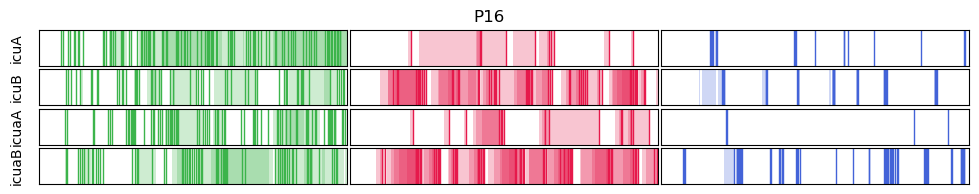

   participant experiment      fuel    system  tracking     total
40         P17       icuA  0.152032  0.176821  0.000000  0.287987
41         P17       icuB  0.196396  0.499884  0.098381  0.623271
42         P17      icuaA  0.000000  0.175265  0.000000  0.175265
43         P17      icuaB  0.495455  0.680457  0.325010  0.795597


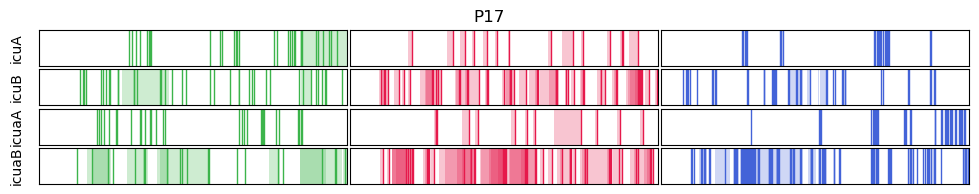

   participant experiment      fuel    system  tracking     total
44         P18       icuA  0.000000  0.126635   0.00000  0.126635
45         P18       icuB  0.178038  0.489941   0.00056  0.560562
46         P18      icuaA  0.000000  0.083707   0.00000  0.083707
47         P18      icuaB  0.000000  0.481855   0.00000  0.481855


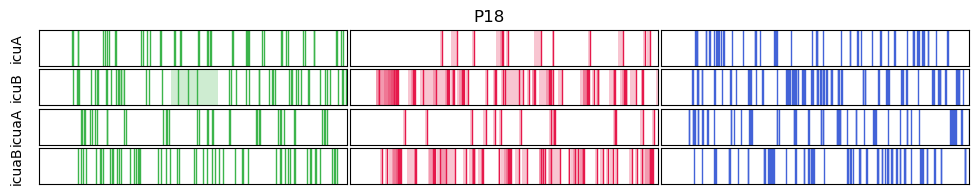

   participant experiment      fuel    system  tracking     total
48         P23       icuA  0.000000  0.129862  0.000000  0.129862
49         P23       icuB  0.601548  0.425244  0.094097  0.791822
50         P23      icuaA  0.000000  0.098092  0.000000  0.098092
51         P23      icuaB  0.444340  0.496517  0.259518  0.728503


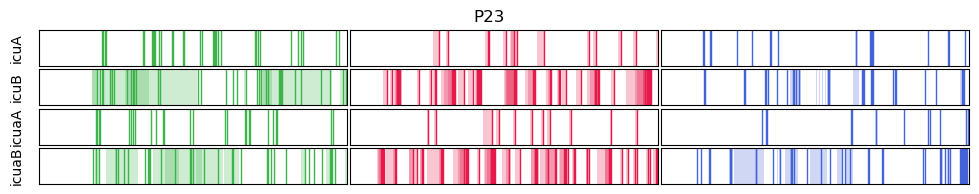

   participant experiment      fuel    system  tracking     total
52         P24       icuA  0.584642  0.217526  0.351387  0.766149
53         P24       icuB  0.663814  0.646785  0.612520  0.888517
54         P24      icuaA  0.747016  0.349106  0.189776  0.810646
55         P24      icuaB  0.737724  0.463195  0.533868  0.867995


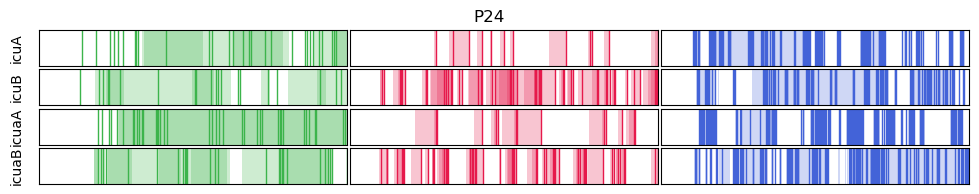

   participant experiment      fuel    system  tracking     total
56         P25       icuA  0.339867  0.162734  0.000000  0.474999
57         P25       icuB  0.218286  0.601533  0.098009  0.709436
58         P25      icuaA  0.748169  0.236059  0.000000  0.761466
59         P25      icuaB  0.610673  0.655569  0.001463  0.822959


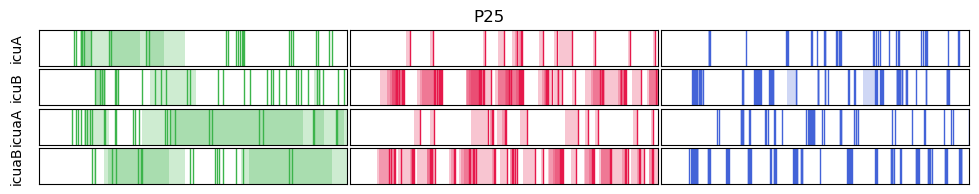

In [8]:
# FAILURE BARS FOR INDIVIDUALS ON EACH TASK 
data = load_nested_dict('data/Processed') 

fp = Statistics.compute_failure_proportion_statistics()

fp = {p:g for p,g in fp.groupby('participant')}

for participant, _data1 in data.items():
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12,2))
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    print(fp[participant])
    for _axes, (experiment, _data2) in zip(axes, _data1.items()):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        _axes[0].set_ylabel(experiment[3:], rotation=90)
        
        _axes = {task:ax for ax,task in zip(_axes, sorted(ALL_WINDOW_PROPERTIES.keys()))}
        # plot failure intervals
        for task, _data3 in sorted(_data2['tasks'].items()):
            ax = _axes[task]
            init_axis(ax, start_time, finish_time)
            intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
            for interval in intervals:
                plot_intervals(interval, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        
        # plot clicks
        mouse_data = _data2['mouse']
        for task, data in mouse_data.groupby(mouse_data['task']):
            for x in data['timestamp']:
                _axes[task].axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1)
        
        # plot keyboard
        kdata = _data2['keyboard']
        for x in kdata['timestamp'][kdata['action'] == 'press']:
            _axes['tracking'].axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1)
        
    #plot_legend(loc=(-1.07, -1))
    fig.suptitle(participant)
    plt.show()
    

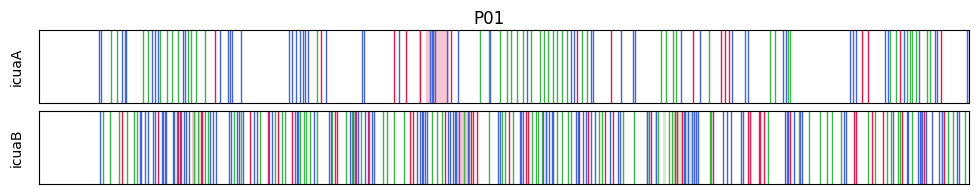

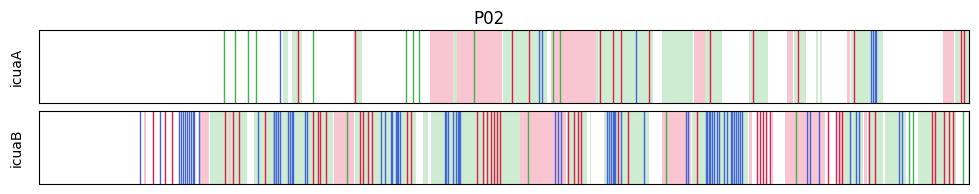

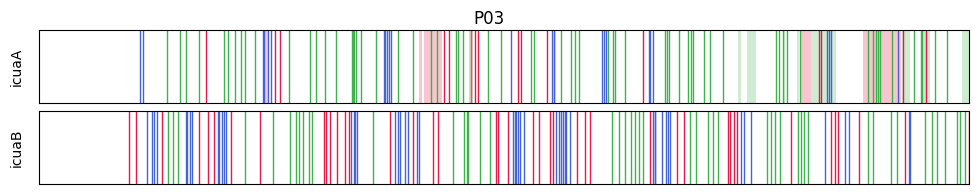

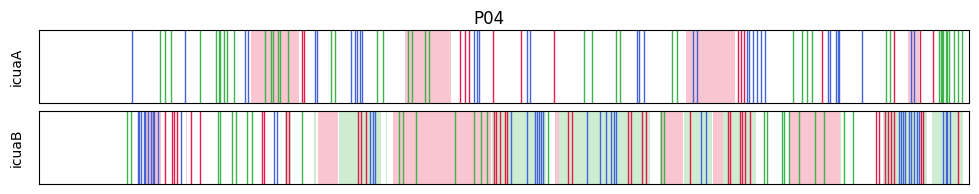

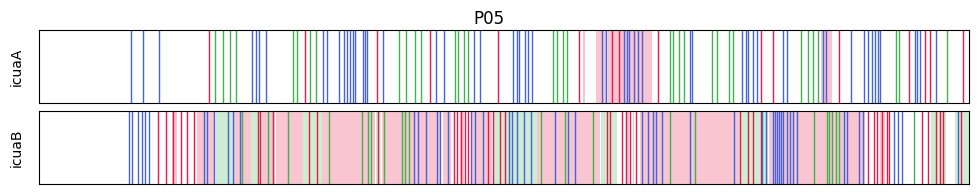

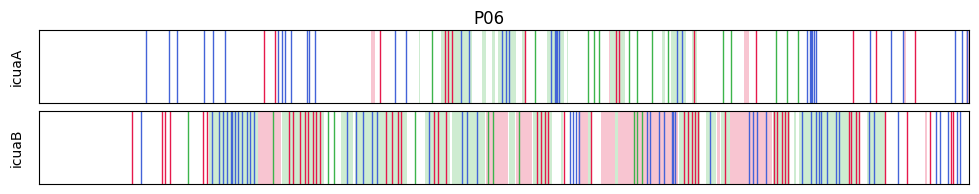

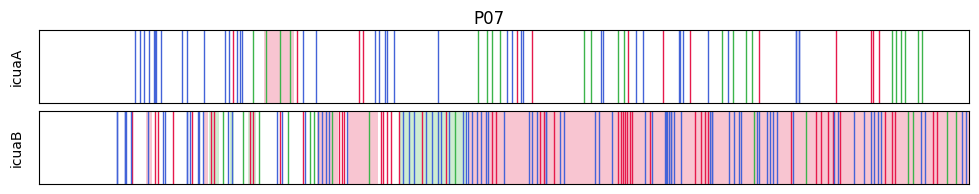

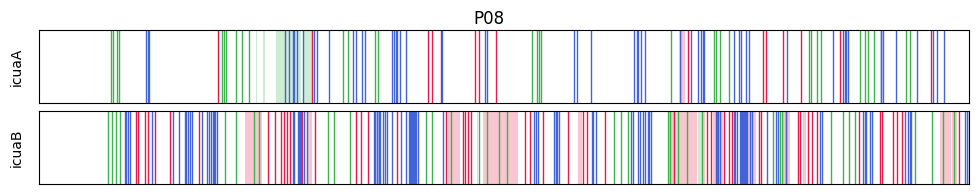

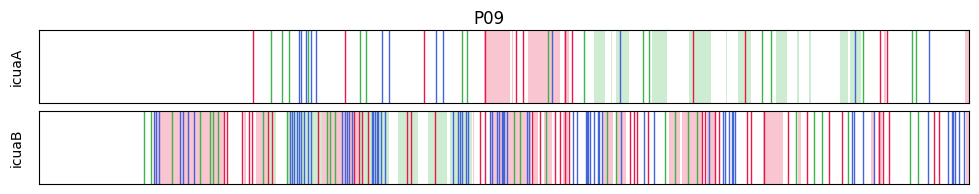

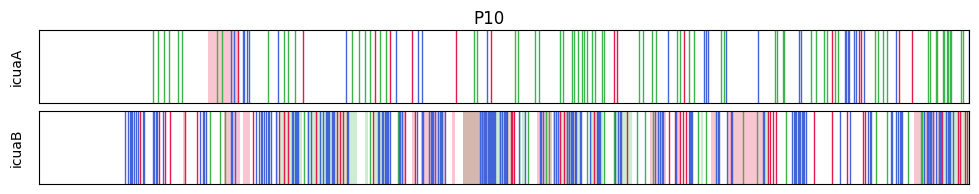

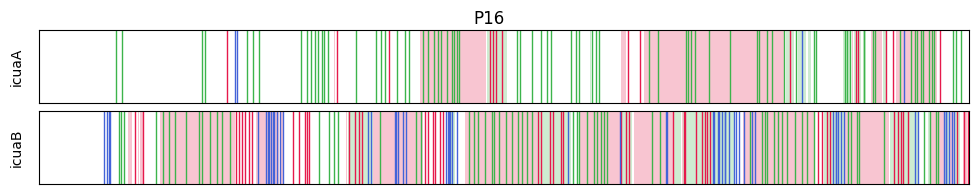

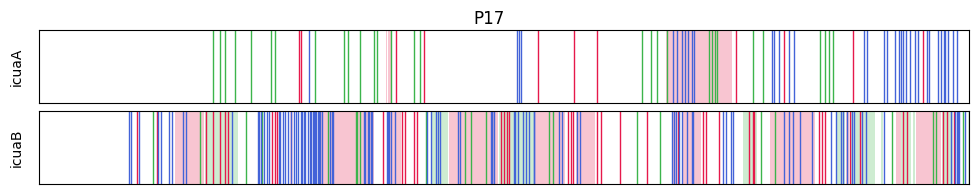

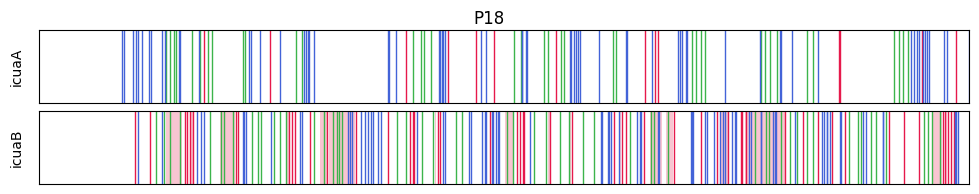

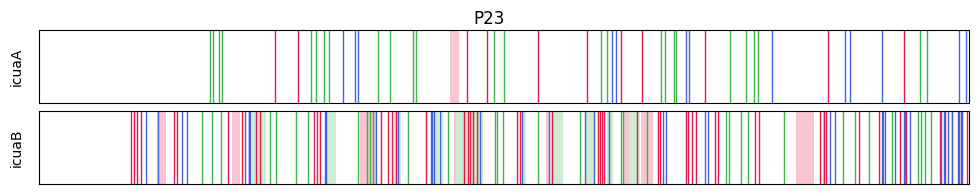

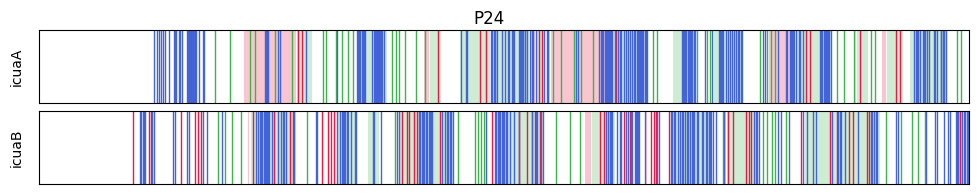

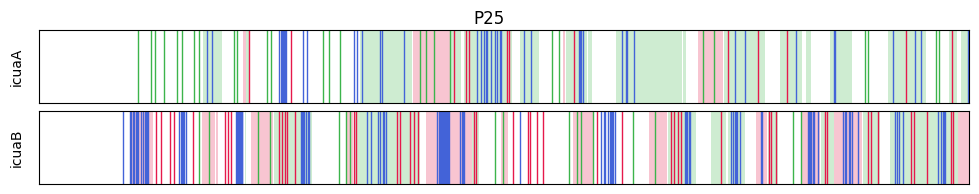

In [4]:
# AGENT FEEDBACK BARS FOR INDIVIDUALS ON EACH TASK 

data = load_nested_dict('data/Processed') 
for participant, _data1 in data.items():
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,2))
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    for ax, (experiment, _data2) in zip(axes, [(k,v) for k,v in _data1.items() if "icua" in k]):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        ax.set_ylabel(experiment[3:], rotation=90)
        init_axis(ax, start_time, finish_time)
        #_axes = {task:ax for ax,task in zip(_axes, sorted(ALL_WINDOW_PROPERTIES.keys()))}
        # plot failure intervals
        for task, task_data in sorted(_data2['warnings'].items()):
            intervals = compute_time_intervals(task_data['value'].astype(int), task_data['timestamp'], start_time, finish_time).intervals
            plot_intervals(intervals, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])

        # plot clicks
        mouse_data = _data2['mouse']
        for task, data in mouse_data.groupby(mouse_data['task']):
            for x in data['timestamp']:
                ax.axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1)

        # plot keyboard
        kdata = _data2['keyboard']
        for x in kdata['timestamp'][kdata['action'] == 'press']:
            ax.axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1)

            
    #plot_legend(loc=(-1.07, -1))
    fig.suptitle(participant)

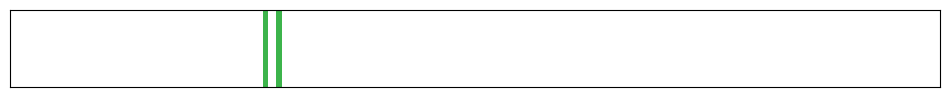

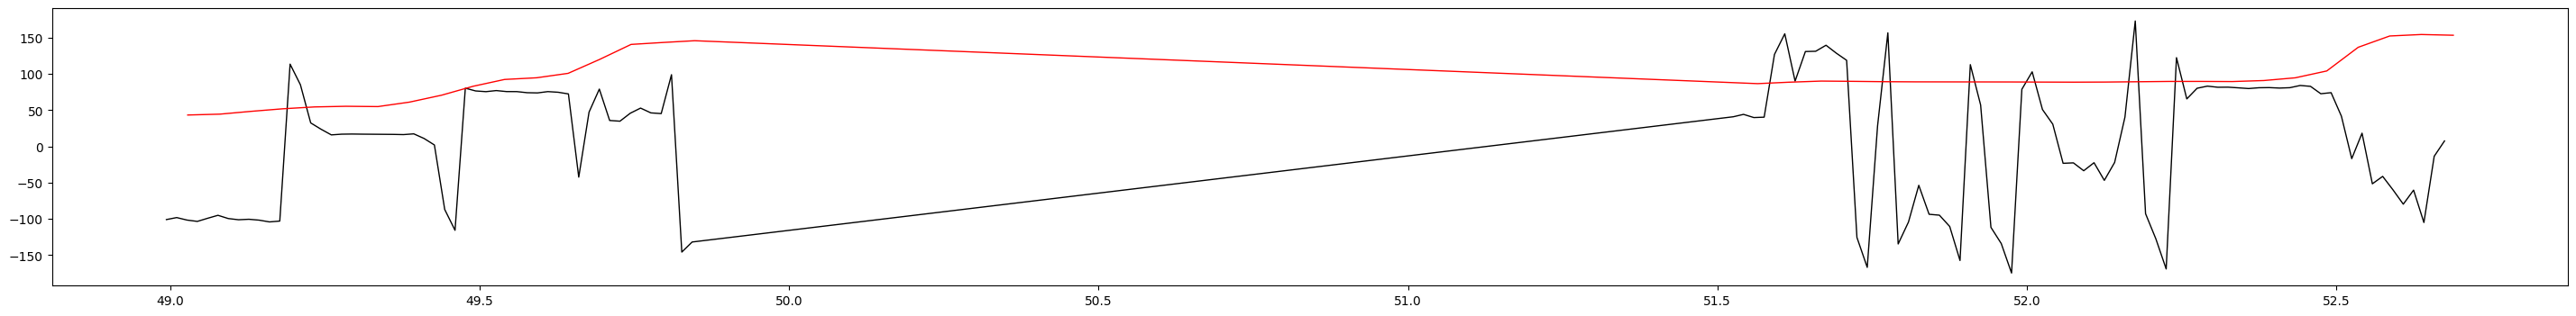

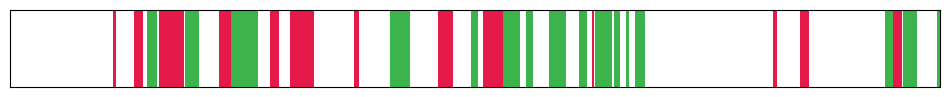

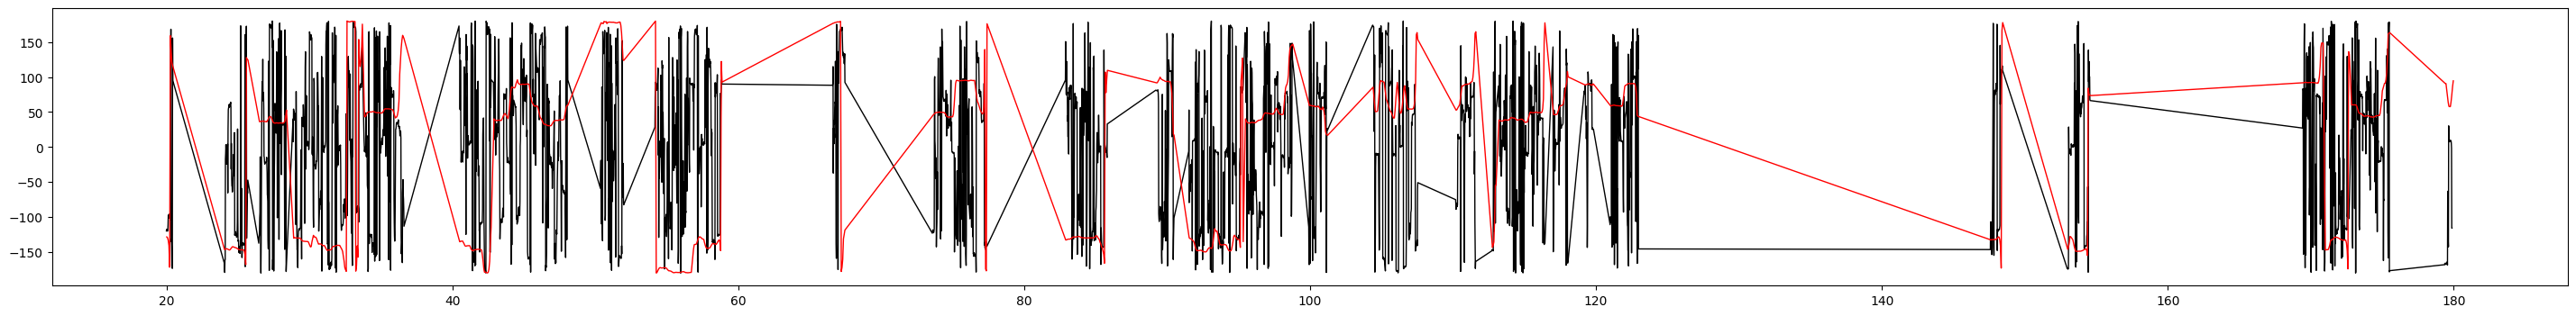

In [7]:
# ANALYSIS OF ARROW AND EYE DIRECTION
data = load_nested_dict('data/Processed') 
def get_index_in_intervals(intervals, x):
    within_intervals = np.logical_and(x[:, np.newaxis] >= intervals[:, 0], x[:, np.newaxis] <= intervals[:, 1])
    return np.where(within_intervals)[0]

def compute_eye_directions(df_eye):
    z = df_eye[['x','y']].to_numpy()
    z1, z2 = z[:-1], z[1:]
    d = z2 - z1
    a = np.arctan2(d[:,1], d[:,0]) * (180/np.pi) # degrees
    a = np.pad(a, (0,1))
    a[-1] = a[-2]
    df_eye['angle'] = a
    return df_eye

for participant, _data1 in data.items():
    for experiment, _data2 in _data1.items():
        if 'icua' in experiment:
            warning_data = _data2['warnings']
            warning_intervals = []
            start_time, finish_time = _data2['start_time'], _data2['finish_time']
            fig = plt.figure(figsize=(12,1))
            init_axis(plt.gca(), start_time, finish_time)
            for task, task_data in warning_data.items():
                intervals = compute_time_intervals(task_data['value'].astype(int), task_data['timestamp'], start_time, finish_time)
                warning_intervals.append(intervals.intervals)
                plot_intervals(intervals.intervals, plt.gca(), color=ALL_WINDOW_PROPERTIES[task]['color'], alpha=1)
                
            # plot arrow data...
            #for t in _data2['arrow']['timestamp']:
            #     plt.gca().axvline(t, color="black", linewidth=1, alpha=0.1)
            eye_data = compute_eye_directions(_data2['eye_tracking'])
            arrow_data = _data2['arrow']
            
            # the warning intervals are when the arrow is shown... get the eye tracking data for these intervals only
            warning_intervals = merge_intervals(warning_intervals)
            indx = get_index_in_intervals(warning_intervals, _data2['eye_tracking']['timestamp'].to_numpy())
            eye_in_warning = eye_data.loc[indx]
            
            plt.figure(figsize=(36,4))
            plt.plot(eye_in_warning['timestamp'] - start_time, eye_in_warning['angle'], color="black", linewidth=1)
            #init_axis(plt.gca(), eye_in_warning['timestamp'].min(), eye_in_warning['timestamp'].max())
            
            plt.plot(arrow_data['timestamp'] - start_time, arrow_data['angle'], color="red", linewidth=1)
            #plt.gca().set_xlim(start_time, finish_time)
            
            #for t in eye_in_warning['timestamp']:
            #     plt.gca().axvline(t, color="black", linewidth=1, alpha=0.01)
        
            
                
    
    
    break
    

In [23]:
np.set_printoptions(suppress=True, formatter={'float': '{: .5f}'.format})


x = np.array([
1629729093.431639,
10.371183400042355,
10.387858999951277,
10.404507800005376,
10.421165900013875,
10.437817900034133,
10.454489000025205,
1629729093.530414])

x[-1] -= x[0]
x[-2] -= x[1]

print(x)

[ 1629729093.43164  10.37118  10.38786  10.40451  10.42117  10.43782
  0.08331  0.09878]


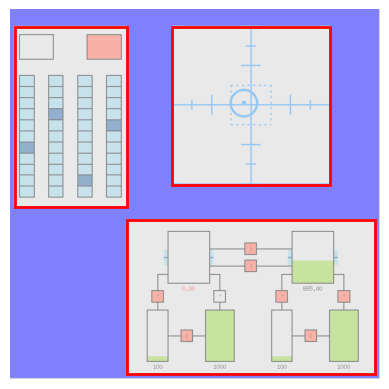

In [14]:

def plot_eyetracking(data, participant, experiment, ax, show_out_of_bounds=False):
    eye_data = data[participant][participant + experiment]['eye_tracking']
    img = ICU_BACKGROUND_IMAGE
    WINDOW_SIZE = (800,800)
    ax.imshow(img, alpha=0.5)
    for _, properties in ALL_WINDOW_PROPERTIES.items():
        rect = plt.Rectangle(properties['position'], *properties['size'], color="red",  linewidth=2, fill=False)
        plt.gca().add_patch(rect)
    if not show_out_of_bounds:
        pass 
        ax.set_xlim(0,WINDOW_SIZE[0])
        ax.set_ylim(0,WINDOW_SIZE[1])
        ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.axis('off')
    
    
data = load_nested_dict('data/Processed') 
participants = list(data.keys())[0]
experiments = list(next(iter(data.values())).keys())

fig = plt.figure()
ax = plt.gca()

plot_eyetracking(data, par, exp[3:], ax, show_out_of_bounds=False)